In [1]:
# autoreload modules
%load_ext autoreload
%autoreload 2

# Generate Dataset

## Mixture of Gaussian

In [434]:
import numpy as np

N = 200_000
M = 100  # Number of quantiles we want to compute
number_of_centers = 2 * (N // (M + 1))  # Number of Gaussian centers
std = 100

# Generate bounds and centers
BOUNDS = [(0, 2 ** i) for i in range(1, 33)]
centers_list = [np.random.uniform(low + 10 * std, high - 10 * std, number_of_centers) for low, high in BOUNDS]

# Distribute samples per center
sample_per_center = [N // number_of_centers] * number_of_centers
for i in range(N % number_of_centers):
    sample_per_center[i] += 1

# Generate datasets
DATASET = [
    {
        "data": (data := np.sort(np.concatenate([
            np.random.normal(center, std, size=n) for center, n in zip(centers, sample_per_center)
        ]))),
        "bounds": (data.min(), data.max()),
        "g": np.min(np.diff(data)),
    }
    for centers in centers_list
]

# Mixtures of Gaussian difficult

In [435]:
import numpy as np



# Generate bounds and centers
BOUNDS = [(0, 2 ** i) for i in range(1, 33)]
centers_list = [np.random.uniform(low + 10 * std, high - 10 * std, number_of_centers) for low, high in BOUNDS]

# Distribute samples per center
sample_per_center = [N // number_of_centers] * number_of_centers
for i in range(N % number_of_centers):
    sample_per_center[i] += 1

# Generate datasets
DATASET = [
    {
        "data": (data := np.sort(np.concatenate([
            np.random.normal(center, std, size=n) for center, n in zip(centers, sample_per_center)
        ]))),
        "bounds": (data.min(), data.max()),
        "g": np.min(np.diff(data)),
    }
    for centers in centers_list
]

# Mixture of consecutive integers

In [1]:
import numpy as np

B = [1e6, 1e7, 1e8, 1e9, 1e10, 1e11, 1e12, 1e13, 1e14, 1e15]
EPS = 1.
g = 1
k_list = [int(100*np.log(B)/EPS) for B in B]
M = 100
DATASET = []
for k, b in zip(k_list, B):
    offset = 0
    data = []
    for _ in range(M):
        new_data = list(range(offset, offset + k))
        data.extend(new_data)
        offset = new_data[-1] + int((b - M * k)/(M - 1))
    DATASET.append({
        "data": data,
        "bounds": (0, b),
        "g": 1,
        "n": len(data),
    })
# ask for the the middle point in each cluster
Q_LIST = [ i / (2 * M) for i in range(1, M + 1)]

# Same dataset twith increasing bounds

In [16]:
import numpy as np
N = 200_000
M = 100  # Number of quantiles we want to compute

data = np.sort(np.random.normal(0, 1, N))
g = np.min(np.diff(data))
# Generate datasets
DATASET = [
    {
        "data": data,
        "bounds": (-2**i, 2**i),
        "g": g,
    }
    for i in range(2, 32)
]

# Set Privacy Budgets

We propose $\varepsilon, \delta$ that are used in SliceQuantiles, and compute the highest $\rho$ for zCDP that implies the same $\varepsilon, \delta$.

In [2]:
from scipy.optimize import root_scalar


def get_max_rho(eps, delta):
    """
    Get the maximum rho for a given epsilon and delta.
    """
    epsilon_func = lambda rho: rho + np.sqrt(4 * rho * np.log(np.sqrt(np.pi * rho) / delta)) - eps

    # Use a numerical solver to find the root of epsilon_func
    result = root_scalar(epsilon_func, bracket=[1e-10, 10], method='brentq')

    if result.converged:
        return result.root
    else:
        raise ValueError("Failed to find a valid rho for the given epsilon and delta.")


eps = 1.
delta = 1e-16
rho = get_max_rho(eps, delta)
print("For eps = {}, delta = {}, max rho = {}".format(eps, delta, rho))

For eps = 1.0, delta = 1e-16, max rho = 0.007055178225814259


# Hyperparameters

In [3]:
EPS = 1.
DELTA = 1e-16
RHO = get_max_rho(EPS, DELTA)
M_LIST = range(10, 100, 10)
Q_LIST = np.array([i / (M + 2) for i in range(1, M + 1)])
SWAP = False
NUM_EXPERIMENTS = 50

In [4]:
records = []  # to store the records of each experiment

In [5]:
import math


def get_statistics(X: np.ndarray, quantiles: np.ndarray, estimates: np.ndarray) -> float:
    """
    Compute the maximum rank error and the mean absolute rank error between the true quantiles and the estimated quantiles.
    :param X: data set
    :param quantiles: a list of quantiles (values in [0, 1])
    :param estimates: a list of estimated qth-quantiles (values in X)
    :return: a dictionary with the maximum rank error and the mean absolute rank error
    """
    # sort the data
    X = np.sort(X)
    n = len(X)

    # for each result, get the position of the closest element in the sorted array
    positions = np.searchsorted(X, estimates)
    true_positions = [math.floor(q * n) for q in quantiles]

    # compute the normalized rank error
    rank_errors = np.abs(positions - true_positions)

    # get statistics
    max_rank_error = np.max(rank_errors)
    mean_rank_error = np.mean(rank_errors)
    output = {
        'max_error':  max_rank_error,
        'mean_error': mean_rank_error  # Kaplan et al. uses this
    }
    return output


# Run SliceQuantiles

## Check correcteness of the privacy parameters

In [6]:
from our_mechanism import SliceQuantile

# Check if the privacy parameters are valid for any values of m
for data_dict in DATASET:
    bound = data_dict["bounds"]
    g = data_dict["g"]
    N = data_dict["n"]
    mechanism = SliceQuantile(bound=bound, n=N, m=len(Q_LIST), eps=EPS, split=0.5, swap=SWAP, g=g)
    if not mechanism.is_delta_approximate_DP(delta=DELTA, q_list=Q_LIST):
        raise ValueError(f"At bound={bound} failed to find a valid delta approximate DP.")
print("All privacy parameters are valid for the given m values.")

All privacy parameters are valid for the given m values.


## Run the experiments

In [7]:
from tqdm import tqdm

for data_dict in tqdm(DATASET):
    bound = data_dict["bounds"]
    data = data_dict["data"]
    g = data_dict["g"]
    N = data_dict["n"]
    mechanism = SliceQuantile(bound=bound, n=N, m=len(Q_LIST), eps=EPS, split=0.5, swap=SWAP, g=g)
    for _ in range(NUM_EXPERIMENTS):
        estimates = mechanism.approximate_mechanism(data, q_list=Q_LIST, delta=DELTA, verbose=True)
        statistics = get_statistics(data, quantiles=Q_LIST, estimates=estimates)
        records.append({
            "B/g": np.log((bound[1]-bound[0]) / g),
            "max_error":  statistics["max_error"],
            "mean_error": statistics["mean_error"],
            "Algorithm":  "SliceQuantile",
        })

100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


# Run Approximate Quantiles, from Kaplan et al.

In [8]:
from DP_AQ import approximate_quantiles_algo

for data_dict in tqdm(DATASET):
    bound = data_dict["bounds"]
    data = data_dict["data"]
    g = data_dict["g"]
    N = data_dict["n"]
    for _ in range(NUM_EXPERIMENTS):
        estimates = approximate_quantiles_algo(array=data, quantiles=Q_LIST, bounds=bound,
                                               epsilon=RHO, swap=SWAP, cdp=True, random_gauss=False)
        statistics = get_statistics(data, quantiles=Q_LIST, estimates=estimates)
        records.append({
            "B/g": np.log((bound[1]-bound[0]) / g),
            "max_error":  statistics["max_error"],
            "mean_error": statistics["mean_error"],
            "Algorithm":  "Approximate Quantiles",
        })

  0%|          | 0/10 [00:00<?, ?it/s]/Users/fabrizioboninsegna/Documents/GitHub/GitHub/DP_CC_quantiles/DP_AQ/single_quantile_algo.py:31: RuntimeWarning: divide by zero encountered in log
  idx_left = racing_sample(np.log(intervals) + (epsilon / (2.0 * sensitivity) * utility))
100%|██████████| 10/10 [00:38<00:00,  3.84s/it]


# Plot the results

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")

DF = pd.DataFrame(records)
# save DF
DF.to_csv("../results/increasing_bounds.csv", index=False)

## Max Error

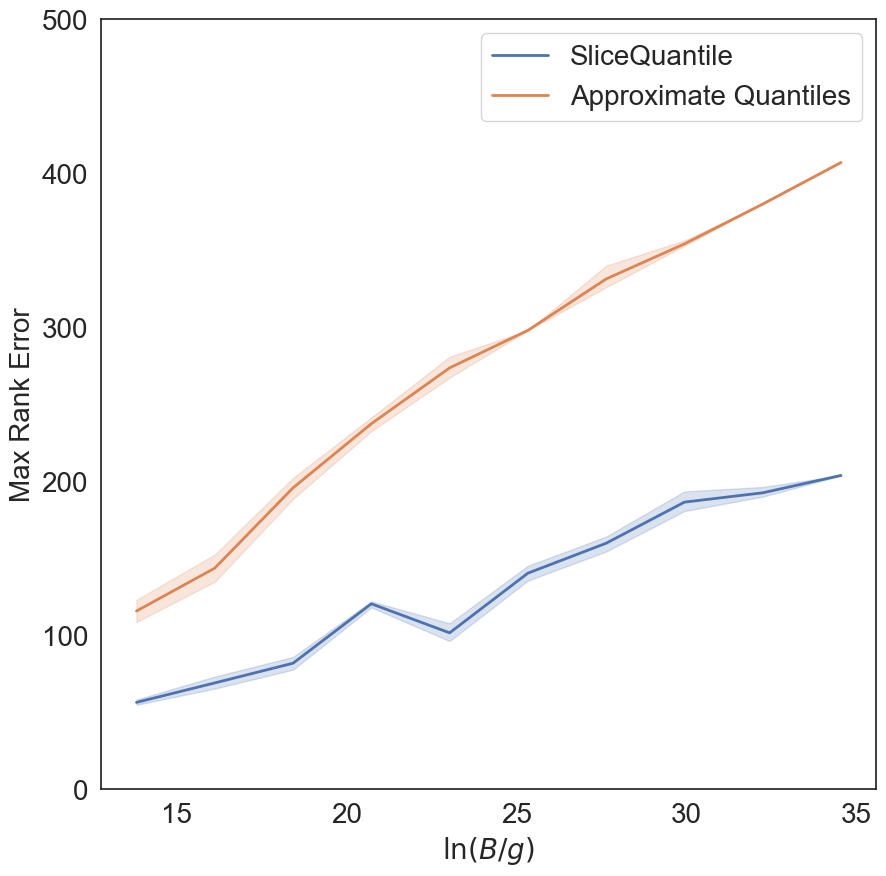

In [15]:
fig = plt.figure(figsize=(10, 10))
sns.lineplot(
    data=DF,
    x="B/g",
    y="max_error",
    hue="Algorithm",
    errorbar=('ci', 95),  # confidence interval 95%
    linewidth=2,
    markers=True,
)
plt.xlabel(r"$\ln(B/g)$", fontsize=20)
plt.ylabel("Max Rank Error", fontsize=20)
plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# set y axis start at 0
plt.ylim(0, 500)
plt.show()



# Mean

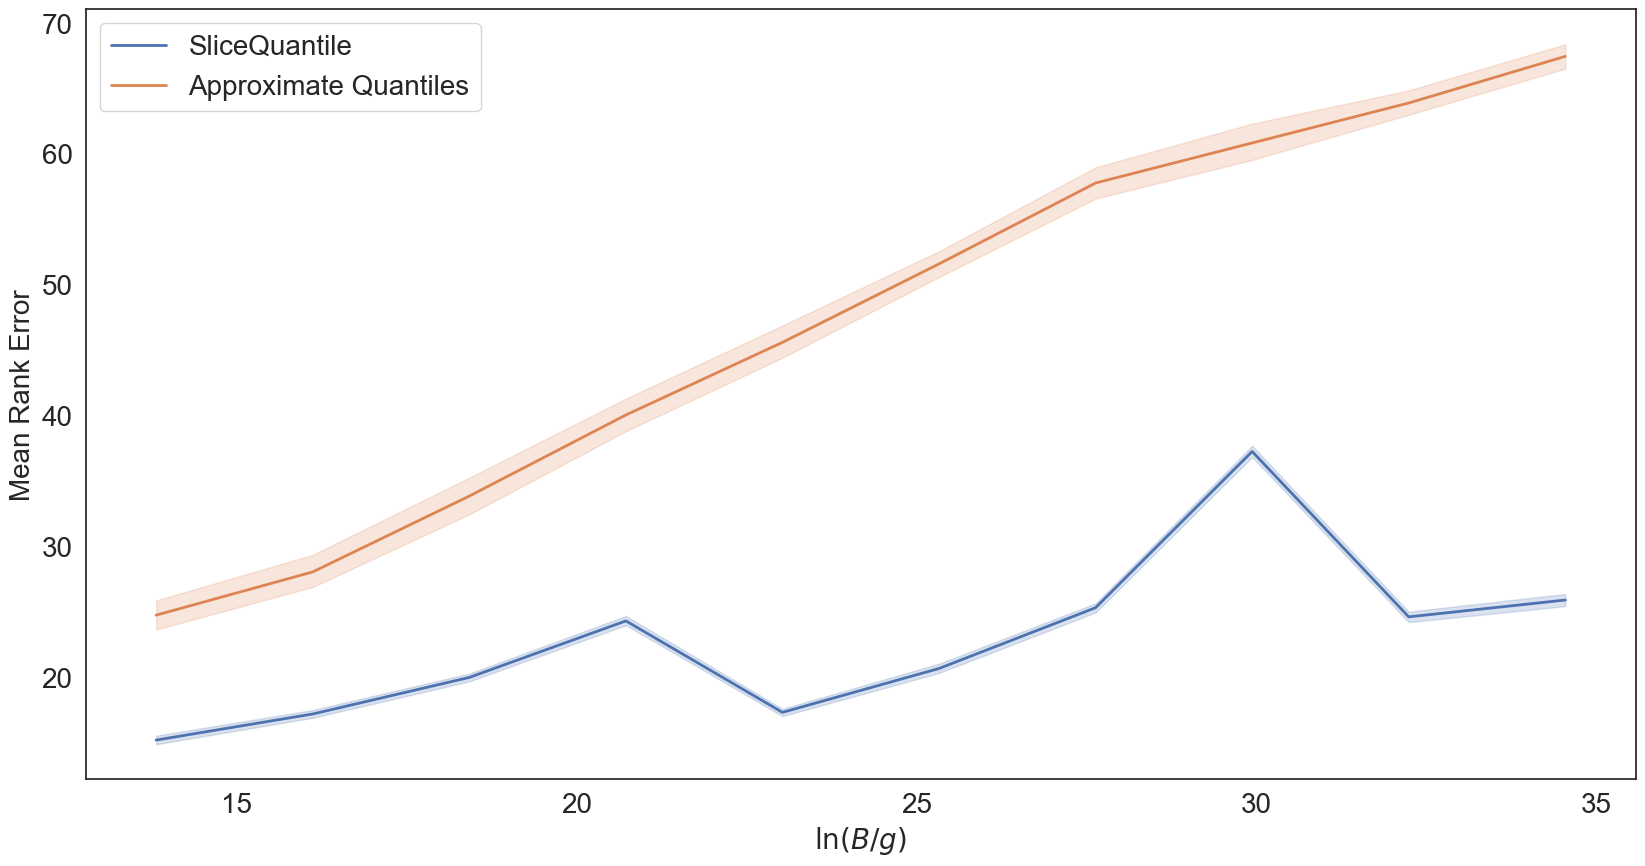

In [11]:
fig = plt.figure(figsize=(20, 10))
sns.lineplot(
    data=DF,
    x="B/g",
    y="mean_error",
    hue="Algorithm",
    errorbar=('ci', 95),  # confidence interval 95%
    linewidth=2,
    markers=True,
)
plt.xlabel(r"$\ln(B/g)$", fontsize=20)
plt.ylabel("Mean Rank Error", fontsize=20)
plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

